### 오버피팅 

- 매개변수가 많고 표현력이 높은 모델

- 훈련 데이터가 적다

In [3]:
import os
import sys

sys.path.append('/Users/krc/Downloads/deep-learning-from-scratch-master')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

In [4]:
# 일부러 오버피팅 시킴

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

epoch:0, train acc:0.09, test acc:0.093
epoch:1, train acc:0.1, test acc:0.1081
epoch:2, train acc:0.12666666666666668, test acc:0.1318
epoch:3, train acc:0.18333333333333332, test acc:0.1585
epoch:4, train acc:0.22, test acc:0.1833
epoch:5, train acc:0.23333333333333334, test acc:0.1991
epoch:6, train acc:0.29, test acc:0.2218
epoch:7, train acc:0.35333333333333333, test acc:0.2435
epoch:8, train acc:0.37666666666666665, test acc:0.257
epoch:9, train acc:0.39666666666666667, test acc:0.2732
epoch:10, train acc:0.4266666666666667, test acc:0.2931
epoch:11, train acc:0.4266666666666667, test acc:0.3031
epoch:12, train acc:0.42, test acc:0.3141
epoch:13, train acc:0.41, test acc:0.3237
epoch:14, train acc:0.4266666666666667, test acc:0.3373
epoch:15, train acc:0.44333333333333336, test acc:0.3552
epoch:16, train acc:0.4266666666666667, test acc:0.3618
epoch:17, train acc:0.45, test acc:0.3725
epoch:18, train acc:0.45, test acc:0.3802
epoch:19, train acc:0.46, test acc:0.3907
epoch:20, tr

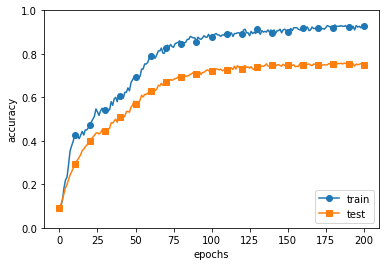

In [6]:
# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda = weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 정확도가 크게 벌어지는건 훈련 데이터에만 적응해버린 결과

### 가중치 감소 

: 학습 과정에서 큰 가중치에 대해서는 상응하는 큰 패널티를 부과하여 오버피팅 억제하는 방법
####
→ 오버피팅은 가중치 매개변수 값이 커서 발생하는 경우가 많다.


#####
▶︎ 신경망 학습의 목적 

: 손실 함수의 값  줄이는 것


#####
• 람다는 정규화의 세기 조절하는 하이퍼파라미터 

→ 크게 설정할수록 큰  가중치에 대한 페널티가 커진다.

In [9]:
import sys, os
sys.path.append('/Users/krc/Downloads/deep-learning-from-scratch-master')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class MultiLayerNet:
    """완전연결 다층 신경망

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        
        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

- 가중치 감소는 간단하게 구현할 수  있고, 어느 정도 지나친 학습을 억제할 수  있다. 

- 신경망 모델이 복잡해지면 가중치 감소만으로는 대응이 어려워진다. 이럴 때  드롭아웃 이용

### 드롭아웃

: 뉴런을 임의로 삭제하면서 학습하는 방법

: 훈련 때  은닉층의 뉴런을 무작위로 골라 삭제 

In [10]:
class Dropout:
    def __init__(self,dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask            

train loss:2.2947637863658423
=== epoch:1, train acc:0.1, test acc:0.0806 ===
train loss:2.3101138206637053
train loss:2.3251938034414126
train loss:2.2982111776199385
=== epoch:2, train acc:0.09333333333333334, test acc:0.0822 ===
train loss:2.2913667116346472
train loss:2.299497146992126
train loss:2.319901185790573
=== epoch:3, train acc:0.11, test acc:0.0863 ===
train loss:2.2907243191322544
train loss:2.2940115642020693
train loss:2.2954562264933513
=== epoch:4, train acc:0.11333333333333333, test acc:0.0895 ===
train loss:2.287769471470877
train loss:2.2869389695331286
train loss:2.2873296764066713
=== epoch:5, train acc:0.12333333333333334, test acc:0.0913 ===
train loss:2.2871043631401595
train loss:2.309980734196905
train loss:2.294366043348253
=== epoch:6, train acc:0.12666666666666668, test acc:0.0954 ===
train loss:2.2845722842564653
train loss:2.2844720410644372
train loss:2.27630173642468
=== epoch:7, train acc:0.13666666666666666, test acc:0.0969 ===
train loss:2.3077454

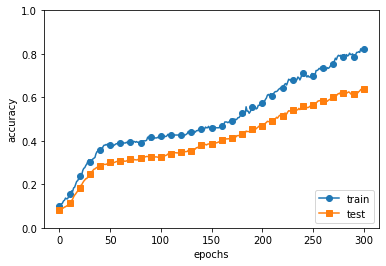

In [11]:
import os
import sys
sys.path.append('/Users/krc/Downloads/deep-learning-from-scratch-master')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 드롭아웃을 이용하면 표현력을 높이면서 오버피팅 억제 가능


#### • 앙상블 학습 

: 개별적으로 학습시킨 여러 모델의 출력을 평균 내어 추론하는 방식


→ 학습 때 뉴런을 무작위로 삭제하는 행위를 매번 다른 모델 학습시키는 것으로 해석되는 드롭아웃과 앙상블은 밀접 


#### • 하이퍼파라미터 

: 예를 들어, 각 층의 뉴런 수, 배치 크기, 매개변수 갱신 시 학습률과 가중치 감소 

→ 값을 적절히 설정하지 않으면 모델의 성능이 크게 떨어지기도 함

##### ★ 주의할 점 ★

: 하이퍼파라미터의 성능 평가 때는 시험 데이터를 사용해서 안 된다. 

: 시험 데이터를 사용해서 조정하면 하이퍼파라미터 값이 시험 데이터에 오버피팅되기 때문

####
• 검증 데이터 

: 하이퍼파라미터 조정할 때 조정용 데이터 

In [12]:
import numpy as np


def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용
    
    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]


def shuffle_dataset(x, t):
    """데이터셋을 뒤섞는다.

    Parameters
    ----------
    x : 훈련 데이터
    t : 정답 레이블
    
    Returns
    -------
    x, t : 뒤섞은 훈련 데이터와 정답 레이블
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


#### • 하이퍼파라미터 핵심 

: 하이퍼파라미터 '최적 값'이 존재하는 범위를 조금씩 줄여간다는 것

: 범위 조금씩 줄이려면 대략적인 범위 설정, 무작위로 값 골라낸 후, 그 값으로 정확도 평가

: 정확도 살피면서 이 작업 여러 번 반복하며 하이터파라미터의 '최적 값'의 범위를 좁혀가는 것



#### • 로그 스케일 지정

: 대략적으로 지정하는 것이 효과적 

: 0.001에서 1,000 사이와 같이 '10의 거듭제곱' 단위로 범위 지정

#### • 하이퍼파라미터 최적화하는 방법

0.  하이퍼파라미터 값 범위 설정

1.  설정된 범위에서 하이퍼파라미터 값 무작위로 추출

2.  1단계에서 샘플링한 값 사용해서 학습하고, 검증 데이터로 정확도 평가 ( 에폭은 작게 설정 )

3.  1, 2단계 특정 횟수 반복하며, 결과 보고 하이퍼파라미터 범위 좁힘

val acc:0.09 | lr:7.655901072830214e-06, weight decay:1.2380689822465065e-05
val acc:0.1 | lr:8.493437968211317e-05, weight decay:4.190597333078865e-06
val acc:0.1 | lr:3.5726046879811797e-06, weight decay:8.613047530339327e-07
val acc:0.14 | lr:5.888840100427415e-05, weight decay:4.912990425938222e-07
val acc:0.08 | lr:5.44174450496251e-06, weight decay:3.7103995947882426e-07
val acc:0.09 | lr:3.529498169871303e-06, weight decay:3.5853321079335914e-07
val acc:0.13 | lr:0.0002746786553812494, weight decay:4.260663598185973e-07
val acc:0.51 | lr:0.003597146907443921, weight decay:1.686630669806563e-05
val acc:0.06 | lr:2.302799718444326e-05, weight decay:5.090350823032233e-05
val acc:0.13 | lr:5.994272394001158e-06, weight decay:7.416807841578642e-07
val acc:0.09 | lr:4.057481622828432e-05, weight decay:5.366491084919974e-07
val acc:0.04 | lr:8.275374745288742e-05, weight decay:7.317969937685735e-08
val acc:0.75 | lr:0.008658610169135677, weight decay:6.82701420346575e-05
val acc:0.14 |

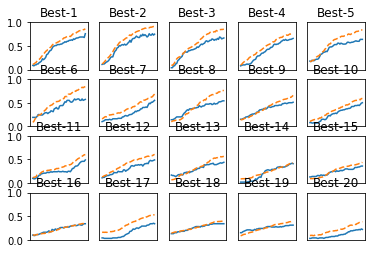

In [13]:
# 하이퍼파라미터 최적화

import sys, os
sys.path.append('/Users/krc/Downloads/deep-learning-from-scratch-master')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

# 학습 잘 진행될 때 학습률은 0.001 ~0.01인 것을 알 수 있다. 
# 잘될 것 같은 값의 범위 관찰하고 범위 좁혀감 → 축소된 범위로 같은 작업 반복 
# 적절한 값이 위치한 범위를 좁혀가다가 특정 단계에서 최종 하이퍼파라미터 값 선택


#### 6장 정리

- 매개변수 갱신 방법 SGD, 모멘텀, AdaGrad, Adam 등 있다.

- 가중치 초깃값 정하는 방법은 매우 중요

- 가중치 초깃값으로는 'Xavier 초깃값'과 'He 초깃값'이 효과적이다.

- 배치 정규화 이용하면 학습을 빠르게 진행할 수 있으며, 초깃값에 영향 덜 받게 된다.

- 오버피팅 억제하는 정규화 기술에는 가중치 감소와 드롭아웃이 있다.

- 하이퍼파라미터 값 탐색은 최적 값이 존재할 법한 범위를 좁히며 하는 것이 효과적이다. 